In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
import cv2
from vit_captioning_analysis import VITCaptioningModel
from vit_captioning_analysis import display_att_map, find_mask_tokens

2023-03-27 14:33:00.484683: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-27 14:33:01.676027: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/braian/anaconda3/envs/thesis/lib/python3.7/site-packages/cv2/../../lib64::/home/braian/anaconda3/envs/thesis/lib/
2023-03-27 14:33:01.678121: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/brai

In [2]:
model = VITCaptioningModel(output_encoder_attentions=True, output_encoder_hidden_states=True)

model running on cpu


/mnt/c/Users/braia/Documents/github/transformers/src/transformers/models/vit/feature_extraction_vit.py:31: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  FutureWarning,


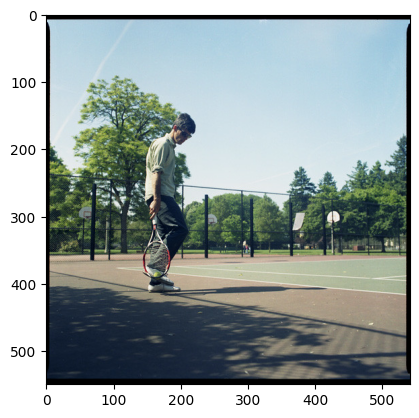

In [3]:
sample_image = Image.open('./526736409_b5dff13989_z.jpg').convert(mode="RGB")
plt.imshow(sample_image)

In [4]:
outputs = model.forward_pass(sample_image)
attention_maps = model.get_all_attention_maps(outputs.encoder_attentions)

In [5]:
outputs.keys()

odict_keys(['loss', 'logits', 'past_key_values', 'encoder_last_hidden_state', 'encoder_hidden_states', 'encoder_attentions'])

### Sanity check

In [8]:
layer_n = 1

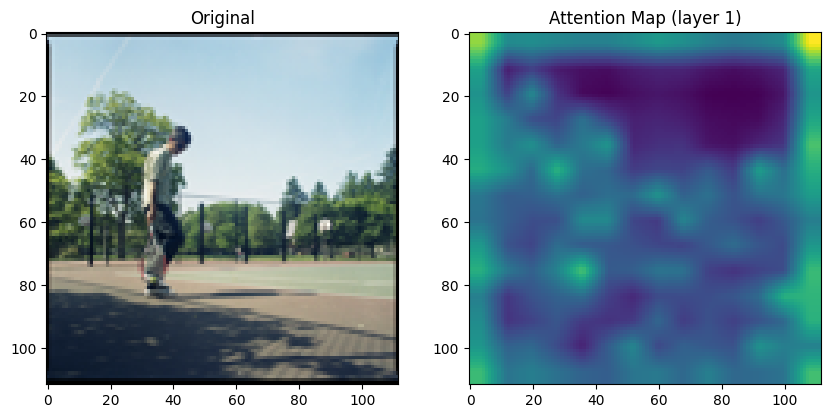

torch.Size([197, 197])


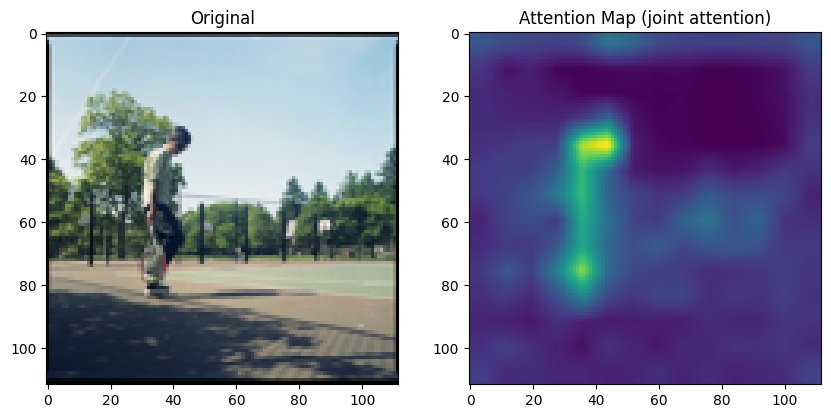

In [9]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 10))

ax1.set_title('Original')
ax2.set_title(f'Attention Map (layer {layer_n})')
_ = ax1.imshow(sample_image.resize((112,112)))
_ = ax2.imshow(display_att_map(attention_maps[layer_n], img_size = (112,112)))

plt.show()

joint_attention_layer = model.get_joint_attention_map(outputs.encoder_attentions)
print(joint_attention_layer.shape)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 10))

ax1.set_title('Original')
ax2.set_title('Attention Map (joint attention)')
_ = ax1.imshow(sample_image.resize((112,112)))
_ = ax2.imshow(display_att_map(joint_attention_layer, img_size = (112,112)))


## Analyze images segmentation GT and attention maps

* each image has a set of `N` objects occurring `i` times
* for each object instance I can check foreground x background analysis and show stats

In [10]:
import json
import os
import pickle
import copy
from tqdm import tqdm
#load annotations
COCO_PATH = "../../../datasets/coco"
grid_size = 14

with open('../task1_person_accessory_data.json', "r") as f:
    task1_data = json.load(f)
    
with open('../filename.pickle', 'rb') as handle:
    category_id_map = pickle.load(handle)    

In [11]:
def add_segmentation(img: Image, annotation, fill="#eeeeff", outline='red'):
    img_draw = ImageDraw.Draw(img)  
    for segm in annotation['segmentation']:
        try:
            if isinstance(segm, list):
                img_draw.polygon(segm, fill=fill, outline=outline)
        except:
            print(segm)
            return img
    return img

def create_fg_mask(img:Image, annotation):
    pil_mask = np.zeros(shape=img.size, dtype=np.uint8)
    pil_mask = Image.fromarray(np.moveaxis(pil_mask, 0, -1))
    img_draw = ImageDraw.Draw(pil_mask) 
    
    for segm in annotation['segmentation']:
        if isinstance(segm, list):
            img_draw.polygon(segm, fill ="#ffffff")
    
    return pil_mask

def pre_process_mask(mask: Image):    
    fg_mask_img = copy.deepcopy(np.array(mask.resize((224,224))))
    fg_mask_img[fg_mask_img==255] = 255
    fg_mask_img[fg_mask_img!=255] = 0
    fg_mask_img = fg_mask_img[:,:,np.newaxis]
    
    return fg_mask_img

In [12]:
task1_data.keys()

dict_keys(['27', '28', '31', '32', '33'])

GT caption  : an image of a man a person holding an umbrella
Pred caption: a man holding an umbrella while walking in the rain 


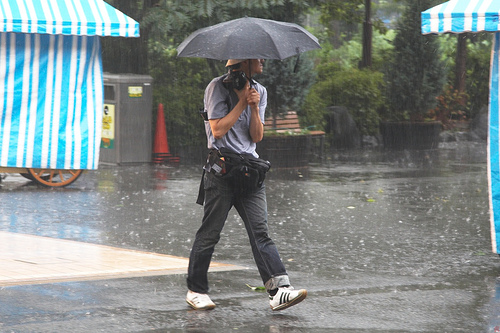

In [16]:
sample_ann = task1_data['28'][3]
sample_img = Image.open(os.path.join(COCO_PATH, 'train2017', sample_ann['image']['file_name'])).convert('RGB')    
print(f"GT caption  : {sample_ann['annotations']['caption']}")
print(f"Pred caption: {model.generate_caption(sample_img)[0]['generated_text']}")
sample_img

In [17]:
object_annotations = [ann for ann in sample_ann['annotations']['annotations'] if ann['iscrowd']==0]
distinct_obj = len(object_annotations)
distinct_obj

4

In [18]:
outputs = model.forward_pass(sample_img)
attention_maps = model.get_all_attention_maps(outputs.encoder_attentions)

In [19]:
for layer in range(12):    
    disp_att_map = display_att_map(attention_maps[layer], img_size = (224, 224))
    print(layer, np.min(disp_att_map), np.max(disp_att_map))

0 0.35155466 0.99389696
1 0.2366686 0.98872983
2 0.1509207 0.9841528
3 0.11945427 0.9823938
4 0.11384515 0.988289
5 0.031200333 0.9432776
6 0.0065908325 0.9396012
7 0.0007306441 0.938612
8 0.00055105286 0.9386119
9 0.0011201466 0.9389877
10 0.00094844145 0.9390909
11 4.567304e-05 0.9449794


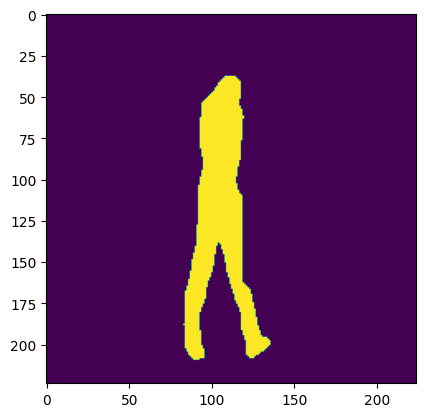

In [20]:
sample_mask = create_fg_mask(sample_img, object_annotations[1])
sample_mask = pre_process_mask(sample_mask)
plt.imshow(sample_mask)

In [21]:
mask_patches = find_mask_tokens(np.array(sample_img.resize((224,224))), sample_mask, .0)[1]
mask_patches

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True,  True, False, False, False, False, False, False,
       False, False,

0.0 0.8296786


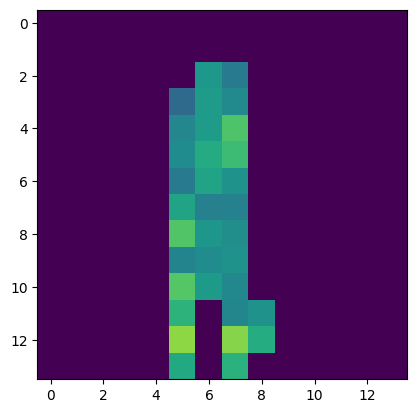

In [22]:
overlaid_att_map = attention_maps[0][0, 1:]
# put into [0,1] scale
overlaid_att_map = overlaid_att_map / overlaid_att_map.max()
overlaid_att_map[~mask_patches] = 0.0
overlaid_att_map = overlaid_att_map.reshape(grid_size, grid_size).cpu().detach().numpy()
# overlaid_att_map = cv2.resize(overlaid_att_map, (224, 224))
print(np.min(overlaid_att_map), np.max(overlaid_att_map))
plt.imshow(overlaid_att_map, vmin=0.0, vmax=1.0)

In [ ]:
for sample_ann in tqdm(task1_data['28']):
    sample_img = Image.open(os.path.join(COCO_PATH, 'train2017', sample_ann['image']['file_name'])).convert('RGB')    

    object_annotations = [ann for ann in sample_ann['annotations']['annotations'] if ann['iscrowd']==0]
    distinct_obj = len(object_annotations)
    
    fig, axs = plt.subplots(nrows=distinct_obj+1, ncols=14, figsize=(55, 4*distinct_obj))
    gt_caption = sample_ann['annotations']['caption']
    pred_caption = model.generate_caption(sample_img)[0]['generated_text']
    fig.suptitle(f"GT :{gt_caption}\nPred: {pred_caption}")

    outputs = model.forward_pass(sample_img)
    attention_maps = model.get_all_attention_maps(outputs.encoder_attentions)
    resized_img = np.array(sample_img.resize((224,224)))

    all_fg_mask = np.zeros(shape=sample_img.size, dtype=np.uint8)
    all_fg_mask = Image.fromarray(np.moveaxis(all_fg_mask, 0, -1))

    for idx, ann in enumerate(object_annotations):
        axs[idx, 0].set_title(f"{category_id_map[ann['category_id']]}")
        axs[idx, 0].imshow(add_segmentation(copy.deepcopy(sample_img), ann).resize((224,224)))    

        mask = create_fg_mask(sample_img, ann)
        mask = pre_process_mask(mask)
        axs[idx, 1].set_title(f"{category_id_map[ann['category_id']]} mask")
        axs[idx, 1].imshow(mask, vmin=0, vmax=255)

        mask_patches = find_mask_tokens(resized_img, mask, .05)[1]    

        # add annotation to the empty all_fg_mask. 
        # in the end reverting it results in the bg_mask
        add_segmentation(all_fg_mask, ann, fill="#ffffff", outline="#ffffff")

        for layer in range(12):    
            overlaid_att_map = attention_maps[layer][0, 1:]
            # put into [0, 1] scale
            overlaid_att_map = overlaid_att_map / overlaid_att_map.max()
            overlaid_att_map[~mask_patches] = 0.0
            overlaid_att_map = overlaid_att_map.reshape(grid_size, grid_size).cpu().detach().numpy()
            axs[idx, layer+2].set_title(f"{layer}")
            axs[idx, layer+2].imshow(overlaid_att_map, vmin=0.0, vmax=1.0)

    axs[idx+1, 0].set_title("all foreground (TODO)")
    axs[idx+1, 0].imshow(resized_img)

    # get background mask by reversing the image mask
    all_fg_mask = pre_process_mask(all_fg_mask)
    bg_mask_img = copy.deepcopy(all_fg_mask)
    bg_mask_img[all_fg_mask==255] = 0
    bg_mask_img[all_fg_mask!=255] = 255
    axs[idx+1, 1].set_title("background mask")
    axs[idx+1, 1].imshow(bg_mask_img, vmin=0, vmax=255)

    mask_patches = find_mask_tokens(resized_img, bg_mask_img, .95)[1]    

    for layer in range(12):    
        overlaid_att_map = attention_maps[layer][0, 1:]
        # put into [0, 1] scale
        overlaid_att_map = overlaid_att_map / overlaid_att_map.max()
        overlaid_att_map[~mask_patches] = 0.0
        overlaid_att_map = overlaid_att_map.reshape(grid_size, grid_size).cpu().detach().numpy()
        axs[idx+1, layer+2].set_title(f"{layer}")
        axs[idx+1, layer+2].imshow(overlaid_att_map, vmin=0.0, vmax=1.0)

    fig.tight_layout()
    fig.subplots_adjust(top=0.88)
    plt.savefig(fname=f"layer_analysis_output_2/{pred_caption}.png")
    plt.close('all')

  0%|                                                                                          | 0/2089 [00:00<?, ?it/s]/mnt/c/Users/braia/Documents/github/transformers/src/transformers/models/vit/feature_extraction_vit.py:31: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  FutureWarning,
/mnt/c/Users/braia/Documents/github/transformers/src/transformers/generation/utils.py:1278: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 20 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,
  2%|█▊                                                                             | 47/2089 [17:46<9:21:36, 16.50s/it]